### Model evaluation. ROC curves, AUC, Precision-Recall curves

- ROC curves depict the relation of the true positive rate (TPR) versus the false positive rate (FPR) as a function of the classification threshold.
- This depiction is helpful in the evaluation of the model under different cost scenarios.

<div>
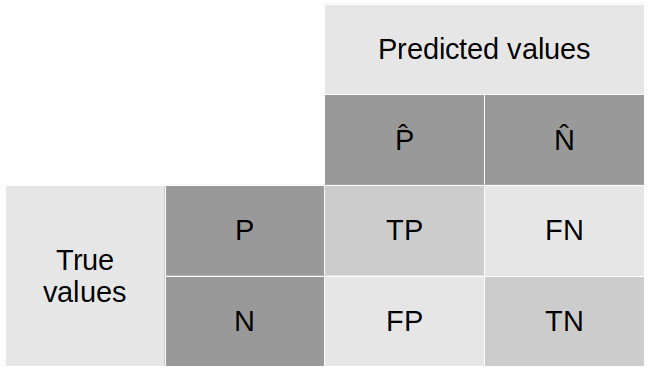
</div>

- **True positive rate**: fraction of positive examples correctly predicted as positives (it is a measure of *quantity*, also called **Recall** or **sensitivity**)

$$TPR=\frac{TP}{P}=\frac{TP}{TP+FN}$$

- **False positive rate**: fraction of predicted positive examples wich are actually negative (it is a measure of *quality* of the prediction)

$$FPR=\frac{FP}{N}=\frac{FP}{FP+TN}$$


### Apunts meus a posteriori (en el moment d'estudiar): 
- 1 = Positius = Malalts
- 0 = Negatius = Sans
<br/>
<br/>
- **TPR** = True positive rate = Recall = $\frac{Predits\,Bé}{Total\,Classe}$
<br/>
<br/>
- **FPR** = False positive rate = $\frac{Predits\,Malament}{Tots\,Els\,Mal} = \frac{Predits\,Pos\,Pero\,Era\,Neg}{Tots\,Els\,Neg}$
    - Proporció que hem predit com a positiu però són negatius &rarr; $\frac{FP}{FP+TN}$
<br/>
<br/>
- **Presició** = Proporció dels que hem predit bé respecte tots els que hem predit com a tal. (predit bé o malament).
- **Recall** = Proporció dels que hem predit bé respecte els que realment ho eren. (predit bé o malament). 
<br/>
<br/>
- **FN** = Hem dit que era *negatiu* però era *positiu*.
- **FP** = Hem dit que era *positiu* però era *negatiu*.
    - Per exemple amb el COVID-19, si ser negatiu és estar sà i positiu estar malalt (infectat). 
        - Fals Positiu era quan et feies un test i sortia positiu (malalt) però en realitat no ho estabes (estabes realment sà). Et quedaves a casa i en veritat estabes bé. 
        - False Negatiu era quan et feies un test i sortia negatiu (sà) però en relitat no ho estabes (estabes realment infecta). Per tant podies sortir de casa infectat (cosa molt més perillosa de predir).
<br/>
<br/>
- **TPR** = Fració de positius predits respecte els que ho són (tots). = Els malalts que tenen una `soft_pred` més gran que el **thr** = $\frac{TP}{Total}$
- **FPR** = Els sans que tenen una `soft_pred` més gran que el **thr** = $\frac{Predits\,Malament}{Tots\,Els\,Neg}$
    - Sans que han passat per positius (malalts)
<br/>
<br/>
<hr/>
<br/>

- Representació del thr en una taula de confusió: 

|Real|$\hat{P}$|$\hat{N}$|
|----|---------|---------|
|P|TP|FN|
|N|FP|TN|
|----1----|&larr; thr &rarr;|----0----|

- Si posem els valors que han sortit a sobre d'aquesta taula ordenats de menys a més (esquerra a dreta), i ho fem com fins ara (el que té mes probabilitat s'emporta el resultat) tindrem un **thr** de 0.5 (perquè estaría justa a la meitat).

||||
|----|---------|---------|
| |0.5 mig|
| |TP: 0.8 - 0.6|FN: 0.4 - 0.2|
|----1----|&larr; thr &rarr;|----0----|

<br/>
<br/>

- Si fem el **thr** &darr; (més petit) llavors (acostar la linia imaginaria que separa el TP del FN), llavors hi haurà menys FN perquè hi ha menys espai (n'entren menys) quan fem la evaluació de si el model l'evaula com a tal o no.

|||
|-|-|
|TP &uarr;|**FN &darr;**|
|FP &uarr;|TN &darr;|

|||
|-|-|
|TP|**FN + cost tenir-ne**|
|FP|TN|

- Consequències de fer això: 
    - Els que predim que si &rarr; és menys fiable (*2). 
    - Però estem baixant els que fallavem (dient ok i estaba malalt). **És on hi ha el cost de fer-ho malament i el que volem evitar**.
    - En el COVID-19. En el test, baixar aquest valor sería: quan et fas el test si surt negatiu (sà) però ets positiu (malalt) té un cost molt elevat, per tant tindría sentit optimitzar així. 
    - Per optimitzar així, tirariem la linia del thr cap a la dreta (fer-lo petit) (la fracció que queda dins dels FN és menor).
   
<br/>
<br/>

- Si fem el **thr** &uarr; (més gran) llavors:

|||
|-|-|
|TP &darr;|FN &uarr;|
|FP &darr;|TN &uarr;|


|||
|-|-|
|TP|FN|
|**FP + cost tenir-ne**|TN|

- Consequències de fer això: 
    - Hem dit que malalt, però no ho era. 
    - Exemple dels mosquits. (Reconeixament de mosquits, no volem que els experts perdin temps amb els que segur que si, sino, que perdin temps evaluant els que hi ha més dubte). Si una persona envia una imatge que no ho és, queda malament dir-li que si automaticament, abans de passar per l'expert. 
    - Quan podem fallar més però a canvi els que si que predim &rarr; són segur que sí, al contrari que (*2).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import gaussian_kde

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prfs

#### dataset

https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/blob/master/diabetes.csv

In [5]:
df = pd.read_csv('../Dades/diabetes/diabetes.csv')

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### map Outcome to target 

In [7]:
df['target'] = df.Outcome.map({0: 'sa', 1: 'malalt'})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target
0,6,148,72,35,0,33.6,0.627,50,1,malalt
1,1,85,66,29,0,26.6,0.351,31,0,sa
2,8,183,64,0,0,23.3,0.672,32,1,malalt
3,1,89,66,23,94,28.1,0.167,21,0,sa
4,0,137,40,35,168,43.1,2.288,33,1,malalt


#### check features (not-null, data-type)

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Train/Test split

In [9]:
Xtrain, Xtest = train_test_split(df, test_size = 0.20, random_state = 52)

#### Prior

In [10]:
pd.concat((Xtrain.target.value_counts(), Xtrain.target.value_counts(normalize = True)), axis = 1)

,target,target
sa,400,0.651466
malalt,214,0.348534


In [11]:
prior = Xtrain.target.value_counts(normalize = True)
prior

sa        0.651466
malalt    0.348534
Name: target, dtype: float64

#### Likelihood functions (all features are continuous)

In [12]:
lkhDict = {Xj: {'lkh0': None, 'lkh1': None} for Xj in Xtrain.columns[:-2]}

In [13]:
for Xj in lkhDict:
    lkhDict[Xj]['lkh0'] = gaussian_kde(Xtrain[Xj].loc[Xtrain.target == 'sa'], bw_method = 'scott')
    lkhDict[Xj]['lkh1'] = gaussian_kde(Xtrain[Xj].loc[Xtrain.target == 'malalt'], bw_method = 'scott')

#### naive-bayes  posterior probability function

In [14]:
def evaluate_post(row):
    post0, post1 = prior
    for Xj in lkhDict:
        post0 *= lkhDict[Xj]['lkh0'].evaluate(row[Xj])[0]
        post1 *= lkhDict[Xj]['lkh1'].evaluate(row[Xj])[0]
    return post0 /(post0 +post1),  post1 /(post0 +post1)

In [15]:
prior

sa        0.651466
malalt    0.348534
Name: target, dtype: float64

##### soft prediction

In [16]:
Xtest['pred_soft'] = Xtest.apply(lambda row: evaluate_post(row), axis = 1)

##### hard prediction

In [17]:
Xtest['pred_hard'] = Xtest['pred_soft'].apply(lambda x: 'malalt' if x[1] > x[0] else 'sa')

In [18]:
Xtest.iloc[:, -4:].head()

,Outcome,target,pred_soft,pred_hard
40,0,sa,"(0.44629826764286107, 0.5537017323571389)",malalt
316,0,sa,"(0.9911761515839266, 0.00882384841607346)",sa
199,1,malalt,"(0.5811320427313371, 0.4188679572686629)",sa
473,0,sa,"(0.32492842660814325, 0.6750715733918567)",malalt
418,0,sa,"(0.9981957211958316, 0.0018042788041684142)",sa


#### confusion matrix

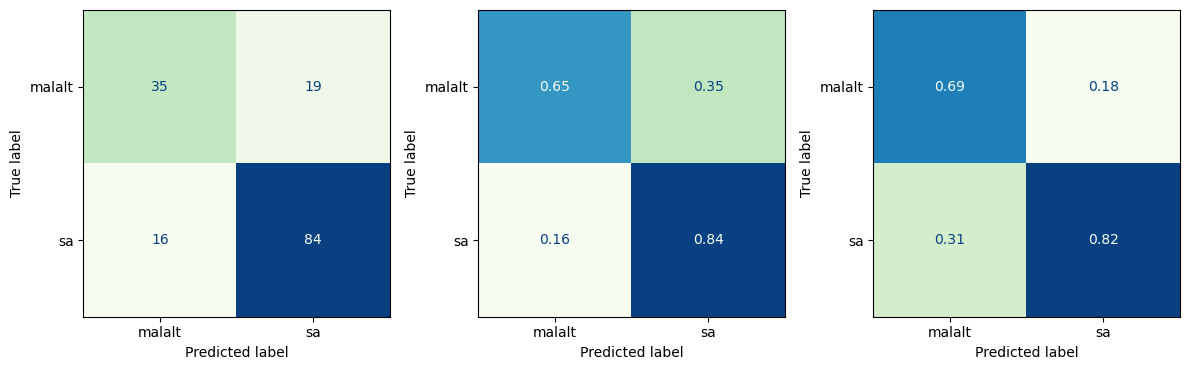

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
for i, norm in enumerate([None, 'true', 'pred']):
    ConfusionMatrixDisplay.from_predictions(
        Xtest.target,
        Xtest.pred_hard,
        normalize = norm,
        ax = axs[i],
        cmap = 'GnBu',
        colorbar = False)
plt.tight_layout()

#### average metrics

In [20]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prfs(Xtest.target, Xtest.pred_hard, average = avg) for avg in avrgs], columns = ['prc', 'rcl', 'f1', 'sup'], index = avrgs)

,prc,rcl,f1,sup
macro,0.750904,0.744074,0.747126,None
micro,0.772727,0.772727,0.772727,None
weighted,0.770209,0.772727,0.771160,None


In [21]:
Xtest.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target,pred_soft,pred_hard
40,3,180,64,25,70,34.0,0.271,26,0,sa,"(0.44629826764286107, 0.5537017323571389)",malalt
316,3,99,80,11,64,19.3,0.284,30,0,sa,"(0.9911761515839266, 0.00882384841607346)",sa
199,4,148,60,27,318,30.9,0.150,29,1,malalt,"(0.5811320427313371, 0.4188679572686629)",sa
473,7,136,90,0,0,29.9,0.210,50,0,sa,"(0.32492842660814325, 0.6750715733918567)",malalt
418,1,83,68,0,0,18.2,0.624,27,0,sa,"(0.9981957211958316, 0.0018042788041684142)",sa


## Aquest model té la premisa de normalitzar les posteriors i les dues sumen 1. 

## La que és més gran guanya el hard prediction


## Ara: 
- Predicció de que un positiu sigui positiu. 
- Si pasa del 0.5 és una cosa i sino una altre (
|Nºmostres|P predits|N predits|recall|
|-|-|-|-|
|P reals|TP|FN|TP / (TP+FN)|
|N reals|FP|TN|TN/(TN+FP)|
|precisió|TP/(TP+FP)|TN/(TN+FN)|**Acc=**(TP+TN)/Nºmostres|

#### ROC curve

Ajuda a buscar el threshold que més interessa

- the *standard* classification criterium is:
    - **positive** when *probability_positive > probability_negative*, **negative** otherwise
    - equivalent to considering a classification $threshold = 0.5$
- ***the ROC curve depicts the relation between TPR and FPR for a classification threshold ranging from 0 to 1.***

In [22]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [23]:
ROC = {}

# Total positius i total negatius
neg, pos = Xtest['Outcome'].value_counts()

# Distribució de valors entre 0 i 1, ho partim entre 101 parts
for thr in np.round(np.linspace(0, 1, 101), 2):
    
    # Per cada llindar/threahod, tpr són els estan malalts i la soft prediction està per sobre del threadhold
    # La probabilitat de malalt és la segona. Està per sobre, per tant true positive, entra al true positive rate
    # La probabilitat d'estar malalt està per sobre del threadhold, el contem i dividim pel total per saber el recall
    # estan malalts i la predicció és més gran que el thread, és un true positive, esta a les esquerra de la barra.
    tpr = Xtest[(Xtest['Outcome'] == 1) & (Xtest['pred_soft'].apply(lambda x: x[1] > thr))].Outcome.count() /pos
    
    # Dels que estan sans, els que estem predin com a malalts. Son sans pero la meva predicció esta per sobre el threadhold
    # Per tant ho contem com a malalt. 
    # Els fp, false positive, els que estan sans (0) però amb la condició de que sigui sa que la probabilitat d'estar malalt
    # està per sobre.
    fpr = Xtest[(Xtest['Outcome'] == 0) & (Xtest['pred_soft'].apply(lambda x: x[1] > thr))].Outcome.count() /neg
    
    # clau threahold: tpr i fpr com a valor
    ROC[thr] = {'tpr': tpr, 'fpr': fpr}

In [24]:
counts = Xtest['Outcome'].value_counts()
counts

0    100
1     54
Name: Outcome, dtype: int64

In [25]:
counts[1]

54

In [26]:
# Els malalts / positius
Xtest[(Xtest['Outcome'] == 1)].head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target,pred_soft,pred_hard
199,4,148,60,27,318,30.9,0.150,29,1,malalt,"(0.5811320427313371, 0.4188679572686629)",sa
322,0,124,70,20,0,27.4,0.254,36,1,malalt,"(0.9240723332320562, 0.07592766676794374)",sa


In [27]:
# Els que la seva soft pred és més gran que el thr
def prova(cell_row):
    condition = cell_row[1] > thr
    # o al return fer-ho entre () pq sinó nomès retorna lo primer.
    return condition

Xtest['prova'] = Xtest['pred_soft'].apply(prova)
Xtest.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target,pred_soft,pred_hard,prova
40,3,180,64,25,70,34.0,0.271,26,0,sa,"(0.44629826764286107, 0.5537017323571389)",malalt,False
316,3,99,80,11,64,19.3,0.284,30,0,sa,"(0.9911761515839266, 0.00882384841607346)",sa,False


In [28]:
Xtest[Xtest['pred_soft'].apply(lambda x: x[1] > thr)].head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target,pred_soft,pred_hard,prova


In [29]:
# Mirem els de la columna outcome i dividim pel total
Xtest[(Xtest['Outcome'] == 1) & (Xtest['pred_soft'].apply(lambda x: x[1] > thr))].Outcome.count() /pos

0.0

**En aquest codi:**

- El TPR, calcula els predits bé respecte tots els reals que teniem. 
    - Agafem tots els malalts que passen el filtre de malalt (true positive)
        - tots els malalts &rarr; (Xtest['Outcome'] == 1)
        - que passen el filtre de malalt &rarr; la soft_pred a la posició 1 és més gran que el thr = Xtest['pred_soft'].apply(lambda x: x[1] > thr))
        - valors soft_pred &rarr; ((% d'estar sa), (% d'estar malalt))
    - Contem quants n'hi ha d'aquests (seríen TP &rarr; true positive) respecte el total de positius (malalts) que tenim (tots) &rarr; per això fa el count de dalt, on ha mirat quants realment estaben malalts. 
<br />
<br />
- El FPR: calcula la proporció que hem predit com a positiu però són negatius &rarr; Predit Pos pero era Neg / Tots els Neg
    - Agafem tots els positius que passen el filtre de malalt (fals positiu)
        - totls els sans &rarr; (Xtest['Outcome'] == 0)
        - que passen el filtre (thr) per ser malalt (positius) &rarr; (Xtest['pred_soft'].apply(lambda x: x[1] > thr))
    - Després igual que l'altre, els contem tots i ho dividim per els negatius en aquest cas.

In [30]:
fpr = Xtest[(Xtest['Outcome'] == 0) & (Xtest['pred_soft'].apply(lambda x: x[1] > thr))].Outcome.count() /neg

In [31]:
ROC[0.50]

{'tpr': 0.6481481481481481, 'fpr': 0.16}

- these results match with the confusion matrix

##### plot the ROC curve

In [32]:
def plotROC(ROC, thr, axs):
    # plot fpr, tpr series
    tpr, fpr = [val['tpr'] for key, val in ROC.items()], [val['fpr'] for key, val in ROC.items()]
    axs.plot(fpr, tpr)
    # show threshold lines
    tpr_thr, fpr_thr = ROC[thr]['tpr'], ROC[thr]['fpr']
    axs.plot((fpr_thr, fpr_thr), (0, tpr_thr), '--r', linewidth = 0.8)
    axs.plot((0, fpr_thr), (tpr_thr, tpr_thr), '--r', linewidth = 0.8)
    axs.text(0.0, (tpr_thr +0.02), 'tpr: %4.2f' %tpr_thr, c = 'r', fontsize = 'x-small')
    axs.text((fpr_thr +0.02), 0.0, 'fpr: %4.2f' %fpr_thr, c = 'r', fontsize = 'x-small')
    # plot diagonal (AUC = 0.5)
    axs.plot((0.0, 1.0), (0.0, 1.0), '--k', linewidth = 0.8);

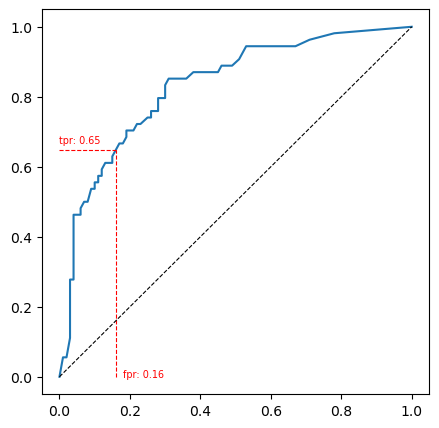

In [33]:
fig, axs = plt.subplots(figsize = (5, 5))
plotROC(ROC, 0.50, axs)

Per buscar el thr més proper al punt (0,1), hauríem de fer algo així: 
- Iterar per tots els valors del diccionary ROC i el que el seu parell de valors tpr i fpr, que representen un punt en l'espai
- El que tingui el modul de la resta dels dos punts / vectores desde el (0,0) més petit, serà el guanyador. Ens quedarem
- Amb la seva key que es thr.
- Per restar els dos punts/vectors, ho fem component a component i per fer el modul, fem servir el teorema de pitagores d'aquestes coordenadess
- Si son vectors, sería respecte l'origen (0,0), llavors, podem fer la operació (resta) directament amb els punts

In [34]:
# punt de dalt a la esquerre:
U = np.array([0, 1])

# Inicialitzem el mínim amb un punt que sería el primer element (un qualsevol)
better_thr = 0
V = np.array([ROC[0]['fpr'], ROC[0]['tpr']])
d_min = np.sqrt(np.sum((U -V)**2))

for key, value in ROC.items():
    V = np.array([value['fpr'], value['tpr']])
    d_uv = np.sqrt(np.sum((U -V)**2))
    ROC[key]['dist'] = d_uv
    
    if d_uv < d_min: 
        d_min = d_uv
        better_thr = key
        
better_thr, d_min, ROC[0.26]

(0.26,
 0.3431876713662333,
 {'tpr': 0.8333333333333334, 'fpr': 0.3, 'dist': 0.3431876713662333})

```python
distances = {
    key : 
    {
        'fpr': value['fpr'],
        'tpr': value['tpr'], 
        'dist': np.sqrt(np.sum((O - np.array([value['fpr'], value['tpr']]))**2))
    }
    
    for key, value in ROC.items()
}

```

In [53]:
# better thr: 
# Punto de la esquina superior izquierda
O = np.array([0, 1])

# Utilizando dict comprehension
distances = {key: {'fpr': value['fpr'], 'tpr': value['tpr'], 'dist': np.sqrt(np.sum((O - np.array([value['fpr'], value['tpr']]))**2))} for key, value in ROC.items()}

min_item = min(distances.items(), key=lambda x: x[1]['dist'])
min_item

(0.26, {'fpr': 0.3, 'tpr': 0.8333333333333334, 'dist': 0.3431876713662333})

In [56]:
min({key: {'fpr': value['fpr'], 'tpr': value['tpr'], 'dist': np.sqrt(np.sum((O - np.array([value['fpr'], value['tpr']]))**2))} for key, value in ROC.items()}.items(), key=lambda x: x[1]['dist'])[0]

0.26

In [54]:
better_thr = min_item[0]
min_distance = min_item[1]['dist']

better_thr, min_distance, ROC[better_thr]

(0.26,
 0.3431876713662333,
 {'tpr': 0.8333333333333334, 'fpr': 0.3, 'dist': 0.3431876713662333})

In [37]:
distances[0.26]

{'fpr': 0.3, 'tpr': 0.8333333333333334, 'dist': 0.3431876713662333}

In [38]:
def plotROC_dist(ROC, axs):
    # plot fpr, tpr series
    tpr, fpr = [val['tpr'] for key, val in ROC.items()], [val['fpr'] for key, val in ROC.items()]
    axs.plot(fpr, tpr)
    # plot diagonal (AUC = 0.5)
    axs.plot((0.0, 1.0), (0.0, 1.0), '--k', linewidth = 0.8);
    # distances
    ROC_list = [(value['fpr'], value['tpr'], value['dist']) for key, value in ROC.items()]
    for point in ROC_list:
        axs.plot([0, point[0]], [1, point[1]], '--', linewidth=0.5, color= 'red' if point[2] == d_min else 'yellow')

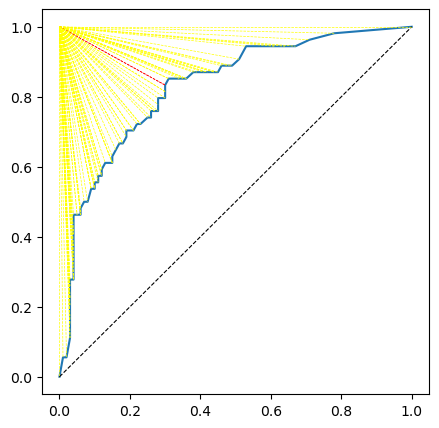

In [39]:
fig, axs = plt.subplots(figsize = (5, 5))
plotROC_dist(ROC, axs)

el threahold és nomès una etiqueta que porta els altres dos i ens serveix per pintar la corba (la corba és el conjunt de punts formats d'evaluar el thr a diferents punts, com hem fet a dalt). 

- threshold = 0 sería a dalt a la dreta de la recta diagonal. Un model que asigna 50% de ser un o de ser l'altre. Els rates valen 1 (false positive rate i l'altre). Perque la linia del mig de la confuxion matrix va a la dreta del tot. Ho començem a tirar-ho cap a la esquerre (del mig de la confusion matrix). Anem baixant per la linia diagonal del mig. 
- a poc que faci bé el model, lu logic es que passin més de true positive que false positive.
- qualsevol model que tinguem si calculem els true/false rate, si l'evaluem per diferents threshold, obtindrem punts que estiguin per sobre la diagonal.
- com més cap a la esquerre, millor ho està fent. 
- com millor model, més la curva tira cap a dalt a les esquerre, a mida que pujem el thread el true positive rate es mante bé. i el false positive rate.
- La curva presenta parells de valors per diferents threadholds, un punt de la corva té el fpr i tpr, per threadhold 0, és el valor que fa que surti a dalt a la dreta. 
- fixa threadhold 0, 0.1, 0.2 ... 1 (amb el pas que vulguis) 0 surt a dalt a la dreta i 1 a baix a la esquerre
- tenim les soft predictions
- mirem quan una observacio és tp a fn i de fp a tn
- calculem els tpr i fpr (valors de dalt) true false positive rate
- això ens va donant dues coordenades, x i y
- En comptes d'afaborir el recall volem afaborir la presicio, aniriem a recalls molt alts, cada cop que es positiu ho hes de debor (no ens equivoquem) diferent del altre. 
- per test covid
- presicio implica que cada vegada que dius que ho està realment ho està
- no vol dir que cada vegada que ho digui ho estiguis
- si ens hem d'equivocar, que és millor, 
- recall millor, si s'ha d'equivocar, que ho faci diguent que té covid quan en ralitat no ho té
- el baixariem per sota del 0.5 pq predis amb més probabilitat els que ho estan (recoll)
- dd
- quin threadhold ens quedem?
- un punt intermig, el punt que està més a prop de la cantonada de dalt a la esquerre. n'hi ha dos.
- dd
- On té més cost equivocar-se? per tirar la ralla cap a la dreta o esquerre. 

### what if we consider a different threshold?

#### Case 1. increase the recall of our model (decrease the  number of FN)

- in the case of a diagnostic model even a moderate *false negative rate* $\text{FNR}=\text{FN}\,/\,\text{P}$ may not be admissible
- we can chose whatever threshold below 0.50 to increase the *TPR* and reduce the *FNR*
- ***the consequence of increasing the TPR is an increase also in the FPR ***

##### example: compute the confusion matrix for threshold = 0.50, 0.40, 0.30

- Calculem tres thr i calcules les prediccions. 
- Mirem que la probabilitat de malalt més alta que el thr, mirem, van del 0 a la dreta al 1 a la dreta. 
- 

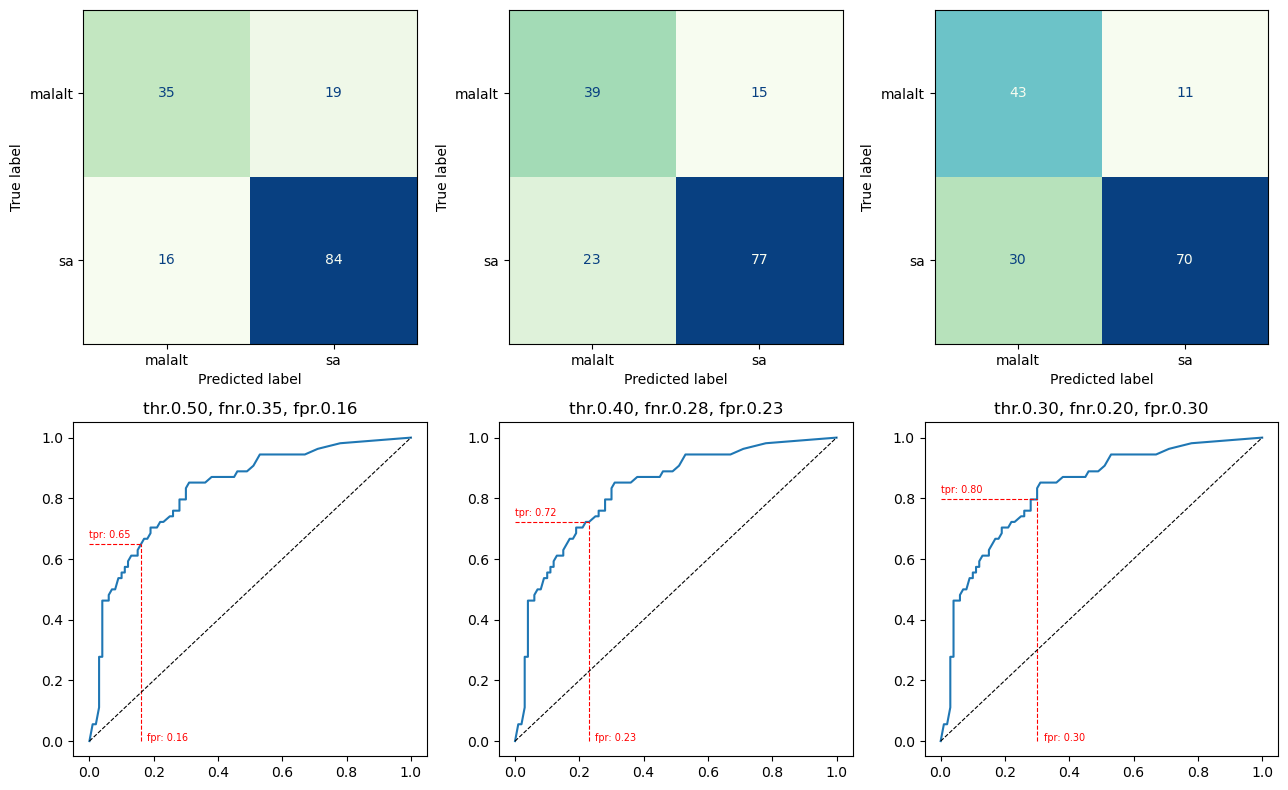

In [40]:
fig, axs = plt.subplots(2, 3, figsize = (13, 8))
for i, thr in enumerate([0.50, 0.40, 0.30]):
    # hard predictions with new threshold
    pred_thr = Xtest['pred_soft'].apply(lambda x: 'malalt' if x[1] > thr else 'sa')
    # confusion matrix with new threshold
    ConfusionMatrixDisplay.from_predictions(
        Xtest.target,
        pred_thr,
        normalize = None,
        ax = axs[0, i],
        cmap = 'GnBu',
        colorbar = False)
    axs[1, i].set_title('thr.%4.2f, fnr.%4.2f, fpr.%4.2f' %(thr, (1 -ROC[thr]['tpr']), ROC[thr]['fpr']))
    # ROC curve
    plotROC(ROC, thr, axs[1, i])
plt.tight_layout();

#### Case 2. increase the precision of our model (decrease the number of FP)

- if our interest were to decrease the FPR we can increase the threshold
- consequently the FNR will increase

El cos fort el tenim en el false positive. Com per exemple en el cas del mosquit tigre, qeu classifica les imatges i el model busca l'especie de la imatge i enviem un sms gracies per la imatge, el mosquit identificat és aquest. resulta que la imatge és un cul xd, gracies jajaja. la reputació baixa, volem un model amb molta presició, en tot cas si no pot identificar amb prou presició, que digui: no he pogut abans que jugarse-la a dir algo, models en que interesa ser precís. no intersesa falsos positius. 

Si es un positiu i no l'hem detectat, tots passen per una revisió humana. Cada imatge que valida sigui bona. Segur que no hi ha un mosquit. aixo es mosquit 99% no cal. 

Moltes no podem classificar, es igual, ja s'ho miraran els experts

##### example

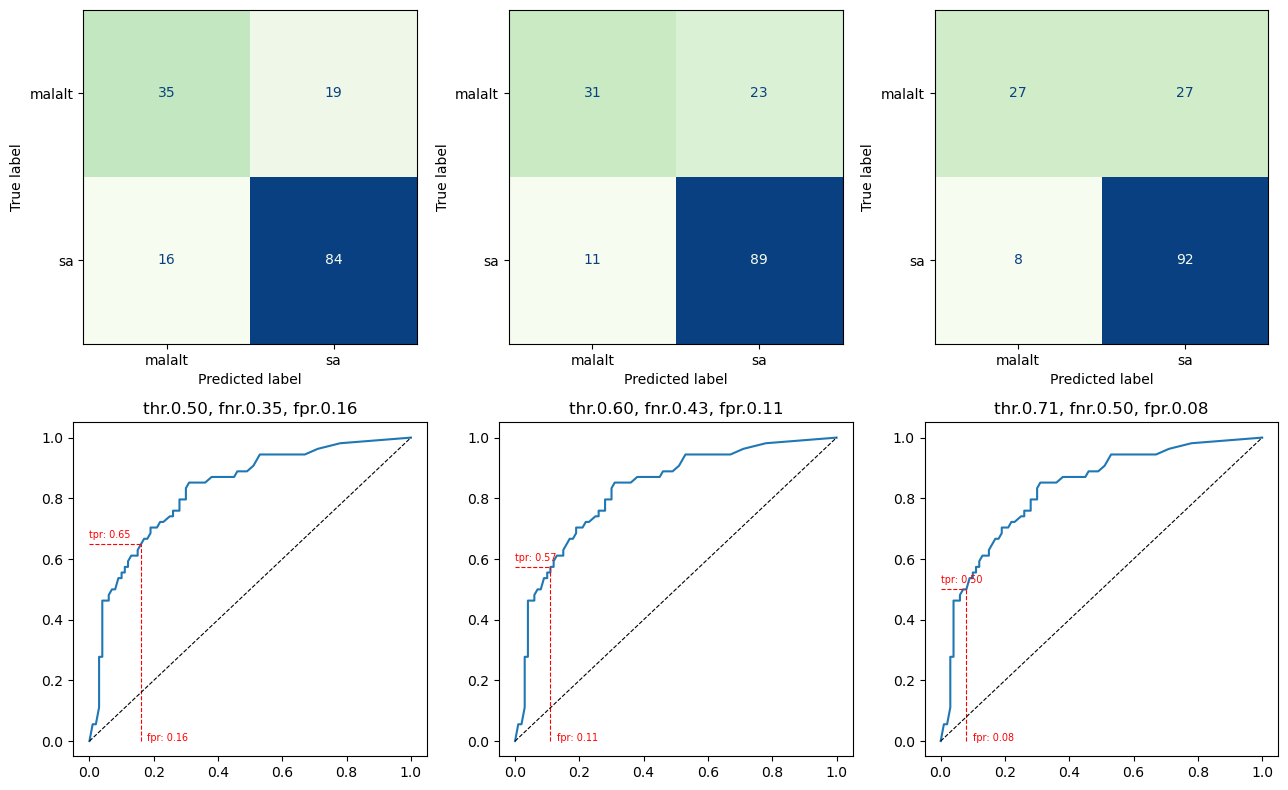

In [41]:
fig, axs = plt.subplots(2, 3, figsize = (13, 8))
for i, thr in enumerate([0.50, 0.60, 0.71]):
    # hard predictions with new threshold
    pred_thr = Xtest['pred_soft'].apply(lambda x: 'malalt' if x[1] > thr else 'sa')
    # confusion matrix with new threshold
    ConfusionMatrixDisplay.from_predictions(
        Xtest.target,
        pred_thr,
        normalize = None,
        ax = axs[0, i],
        cmap = 'GnBu',
        colorbar = False)
    axs[1, i].set_title('thr.%4.2f, fnr.%4.2f, fpr.%4.2f' %(thr, (1 -ROC[thr]['tpr']), ROC[thr]['fpr']))
    # ROC curve
    plotROC(ROC, thr, axs[1, i])
plt.tight_layout();

El recall baixa però els falsos positius baixen gairabé a zero. 

Aquí el punt més proper no és el millor

Això depen de la interpretació del cost de fer l'error. 

el thr optim que s'acosta a la punta, seria en el cas que els costos siguin equivalents. Inclus quan els costos siguin iguals, el 0.5 no és la millor opció. true positve rate alt cap a la dreta false negative rate baix cap a la esquerre.

Si sumes els de la diagonal invertida siguin els minims, minimitza l'error. Potser si el dataset estigues 50% sería així. Podem tenir una variable que biaixa les dades cap a un lloc. 

Dir que algo que té 30% de ser blanc dir-ho, ens pot ajudar perque potser que el dataset com estigui construit nomès representa una part de la realitat.

### using scikit-learn metrics module

In [42]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [43]:
FPR, TPR, thresholds = roc_curve(Xtest['Outcome'], Xtest['pred_soft'].apply(lambda x: x[1]), pos_label = 1)

##### plot ROC using our plotRoc() function

In [44]:
roc = {np.round(thr, 4): {'fpr': fpr, 'tpr': tpr} for thr, fpr, tpr in zip(thresholds, FPR, TPR)}

In [45]:
thr50 = [thr for thr in roc.keys() if thr > .50][-1]
thr50, roc[thr50]

(0.5044, {'fpr': 0.16, 'tpr': 0.6481481481481481})

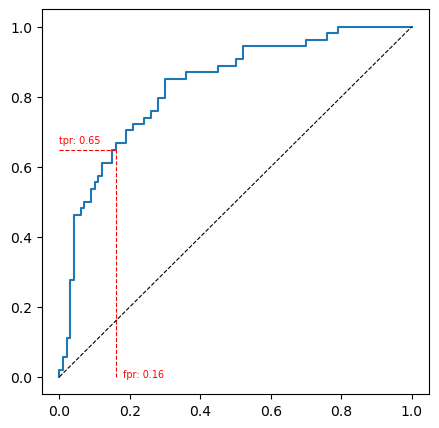

In [46]:
fig, axs = plt.subplots(figsize = (5, 5))
plotROC(roc, 0.5044, axs)

#### area-under-the-curve (AUC)
- AUC is another global measure of performance that takes into account the whole range of thresholds
- $0\le AUC\le 1$; 0 meaning a random model and 1 meaning a perfect model

In [47]:
roc_auc = auc(FPR, TPR)
roc_auc

0.8311111111111111

##### plot ROC using sklearn.metrics.RocCurveDisplay()

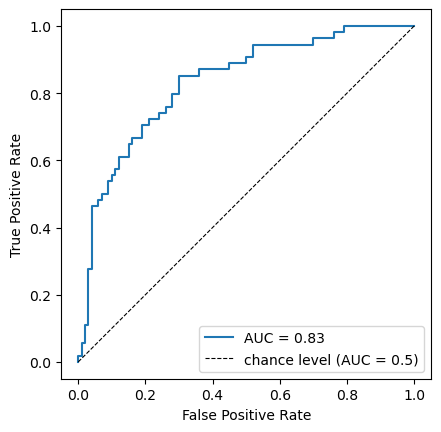

In [48]:
RocCurveDisplay(fpr = FPR, tpr = TPR, roc_auc = roc_auc).plot()
plt.plot([0, 1], [0, 1], "k--", linewidth = 0.8, label = "chance level (AUC = 0.5)")
plt.axis("square")
plt.legend();

### Precision-Recall curves

In [49]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [50]:
prc, rec, thr = precision_recall_curve(Xtest['Outcome'], Xtest['pred_soft'].apply(lambda x: x[1]), pos_label = 1)

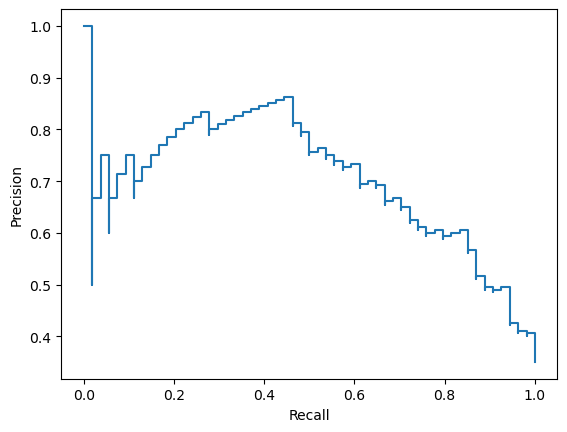

In [51]:
PrecisionRecallDisplay(precision = prc, recall = rec).plot();